# Classfication Evaluation

In [1]:
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../modules/'))
sys.path.insert(1, os.path.join(sys.path[0], '../data_creation/'))
sys.path.insert(1, os.path.join(sys.path[0], '../networks/'))
sys.path.insert(1, os.path.join(sys.path[0], '../network_trainers/'))

from CNN_DS_BN_C import CNN_DS_BN_C
from CNN_DS_BN_BC import CNN_DS_BN_BC
from Data_Creator_C import Data_Creator_C
from data_manipulation import *
import tensorflow as tf
import numpy as np

In [3]:
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [4]:
_, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())
# training_baselines_data = get_seps_data(training_redundant_baselines_dict, uvd)
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

## Load in data

In [6]:
# Find all the different antennas for this data set and extract the max value
unique_ants = []
# for sep_pair in evaluation_seps:     
for key in testing_redundant_baselines_dict.keys():
    for sep in testing_redundant_baselines_dict[key]:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)
max_ant = np.max(unique_ants)       

In [7]:
generated_ant_delays = {ant : np.random.uniform(low = -0.010, high = 0.010) for ant in unique_ants}

In [8]:
_bl_data = testing_baselines_data

In [9]:
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [10]:
_bl_dict = testing_redundant_baselines_dict

In [11]:
_gains = gains

In [12]:
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

In [13]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [14]:
def get_target(two_seps, d):
    return np.sum([d[ant] for ant in np.array(two_seps).flatten()])

In [105]:
num_V_ratios = 10000
inputs = []
targets = []
evaluation_seps = []
angle_tx  = lambda x: (np.asarray(x) + np.pi) / (2. * np.pi)


nu = np.arange(1024)
for i in range(num_V_ratios):
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    evaluation_seps.append(two_seps)
        
    
    target = get_target(two_seps, generated_ant_delays)
    targets.append(target)

    input_rect = angle_tx(np.angle(_flatness(two_seps)*np.exp(-2j*np.pi*(nu*target + np.random.uniform()))))
    
    # randomly select one row
    inputs.append(input_rect[np.random.randint(60)])
    
# permutation_index = np.random.permutation(np.arange(num_V_ratios * 60))
# bc_labels = [[1,0] if d >=0 else [0,1] for d in np.array(targets)[permutation_index]]
# inputs = inputs[permutation_index]

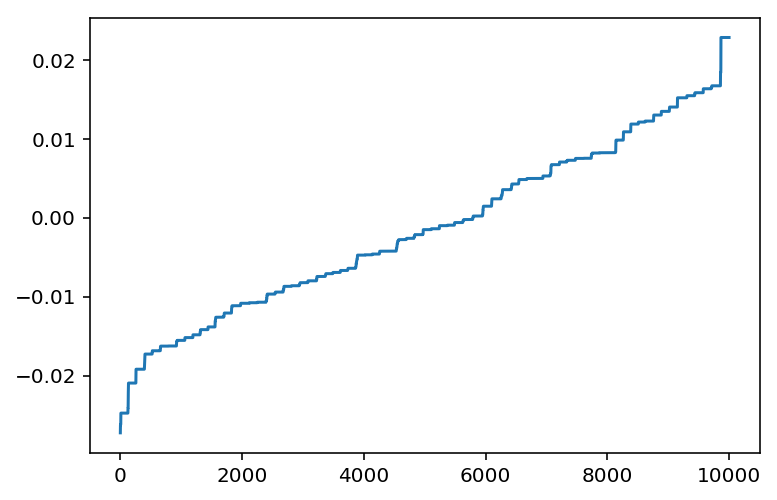

In [106]:
plt.plot(sorted(targets))

In [107]:
np.mean(np.array(targets) > 0)

0.4208

***

## Evaluate magnitude of delay

In [110]:
network = CNN_DS_BN_C('CNN_DS_BN_C_2_401_aug7_e_evaluation_test', 3, 401)
network.load_params('../logs/CNN_DS_BN_C_2_401_aug7_e/params/CNN_DS_BN_C')
network.print_params()

params loaded{'adam_initial_learning_rate': 0.0001,
 'log_dir': '../logs/',
 'name': 'CNN_DS_BN_C_2_401_aug7_e_evaluation_test',
 'num_classes': 401,
 'num_downsamples': 3}


In [111]:
network.create_graph()
saver = tf.train.Saver()
with tf.Session() as session:

    saver.restore(session,'../logs/CNN_DS_BN_C_2_401_aug7_e/trained_model.ckpt-1000')
   
    eval_feed_dict = {network.X: np.array(inputs).reshape(-1,1,1024,1),
                      network.sample_keep_prob : 1.,
                      network.conv_keep_prob : 1.,
                      network.is_training : False}

    predicted_labels = session.run([network.predictions], feed_dict = eval_feed_dict)

network Ready - 3381405 trainable parametersINFO:tensorflow:Restoring parameters from ../logs/CNN_DS_BN_C_2_401_aug7_e/trained_model.ckpt-1000


***
## Evaluate sign of delay

In [112]:
tf.reset_default_graph()
network_pos_neg = CNN_DS_BN_C('CNN_DS_BN_C_aug8_POSNEG_evaluation_test', 3, 2)
network_pos_neg.load_params('../logs/CNN_DS_BN_C_2_401_aug7_POSNEG/params/CNN_DS_BN_C')

network_pos_neg.create_graph()
saver_pos_neg = tf.train.Saver()
with tf.Session() as session_pos_neg:

    saver_pos_neg.restore(session_pos_neg,'../logs/CNN_DS_BN_C_2_401_aug7_POSNEG/trained_model.ckpt-5490')
    

    eval_feed_dict_pos_neg = {network_pos_neg.X: np.array(inputs).reshape(-1,1,1024,1),
                              network_pos_neg.sample_keep_prob : 1.,
                              network_pos_neg.conv_keep_prob : 1.,
                              network_pos_neg.is_training : False}

    predicted_labels_pos_neg = session_pos_neg.run([network_pos_neg.predictions], feed_dict = eval_feed_dict_pos_neg)

network Ready - 112398 trainable parametersINFO:tensorflow:Restoring parameters from ../logs/CNN_DS_BN_C_2_401_aug7_POSNEG/trained_model.ckpt-5490


In [113]:
test_pn = np.array(predicted_labels_pos_neg[0])
np.mean(test_pn, axis = 0)

array([0.42228994, 0.5777103 ], dtype=float32)

### make a dictionary of : 
 {true_delay, top_guesses, probabilites_for_each_guess, {sign_of_guess : probability_of_sign}}

In [128]:
top_num = 3
evaluations = []

# check each magnitude prediction individually
for i, a in enumerate(np.array(predicted_labels).reshape(-1,401)):
    
    # index of the highest 3 probabilities
    ind = np.argpartition(a, -top_num)[-top_num:]
    
    # for each probability get the associated class
    picks = []
    percs = []
    for j in ind:
        
        picks.append(classes[j])
        percs.append(np.round(a[j],5))
        
    # get the highest probability
    idx = np.argsort(percs)
    
    # get the corresponding positive-negative prediction
    sPerc = predicted_labels_pos_neg[0][i]
    
    # assing positive or negative label
    s = {"pos" : np.round(np.max(sPerc),4)} if np.argmax(sPerc) == 0 else {"neg" : np.round(np.max(sPerc),4)}
    
    
    # create evaluation dictionary
    evaluation = {}
    
    # the actual value 
    evaluation['_true'] = targets[i]
    
    # the top 3 guessed values
    evaluation['top_3'] = [x for x in np.array(picks)[idx][::-1]]
    
    # the top 3 guessed values probabilities
    evaluation['top_3_probs'] = [x for x in np.array(percs)[idx][::-1]]
    
    # the sign 
    evaluation['sign'] = s
    evaluation['_guess'] = evaluation['top_3'][0] if s.keys()[0] == 'pos' else -1*evaluation['top_3'][0]
    evaluation['error'] = evaluation['_true'] - evaluation['_guess']

    evaluation['absolute_error'] = np.abs(evaluation['_true'] - evaluation['_guess'])
    evaluations.append(evaluation)
                                      

### Print some to take a look

In [129]:
from pprint import pprint as pPrint

In [130]:
for x in evaluations[0:10]:
    pPrint(x)
    print('\n')

{'_guess': 0.014100000000000001,
 '_true': 0.01402582880425017,
 'absolute_error': 7.417119574983089e-05,
 'error': -7.417119574983089e-05,
 'sign': {'pos': 1.0},
 'top_3': [0.014100000000000001, 0.0142, 0.014],
 'top_3_probs': [0.041, 0.04092, 0.04071]}


{'_guess': 0.0164,
 '_true': 0.016343593945049292,
 'absolute_error': 5.640605495070908e-05,
 'error': -5.640605495070908e-05,
 'sign': {'pos': 1.0},
 'top_3': [0.0164, 0.0165, 0.0166],
 'top_3_probs': [0.04031, 0.04027, 0.03991]}


{'_guess': -0.0053,
 '_true': -0.004734412961906264,
 'absolute_error': 0.0005655870380937358,
 'error': 0.0005655870380937358,
 'sign': {'neg': 1.0},
 'top_3': [0.0053, 0.005200000000000001, 0.0051],
 'top_3_probs': [0.03383, 0.03383, 0.03365]}


{'_guess': -0.0024000000000000002,
 '_true': -0.0026083388567339806,
 'absolute_error': 0.00020833885673398039,
 'error': -0.00020833885673398039,
 'sign': {'neg': 1.0},
 'top_3': [0.0024000000000000002, 0.0025, 0.0023],
 'top_3_probs': [0.03965, 0.03961, 0.0391

In [131]:
errors = [x['error'] for x in evaluations]
abs_errors = [x['absolute_error'] for x in evaluations]
best_guesses = [x['_guess'] for x in evaluations]
combined_prob = [x['top_3_probs'][0]*x['sign'].values()[0] for x in evaluations]

std(error) = 0.000238981286848
percent of errors less than 0.0001 (~1ns)= 0.7513
percent of errors less than 0.0005 (~5ns)= 0.983
percent of errors less than 0.00075 (~7.5ns)= 0.9945


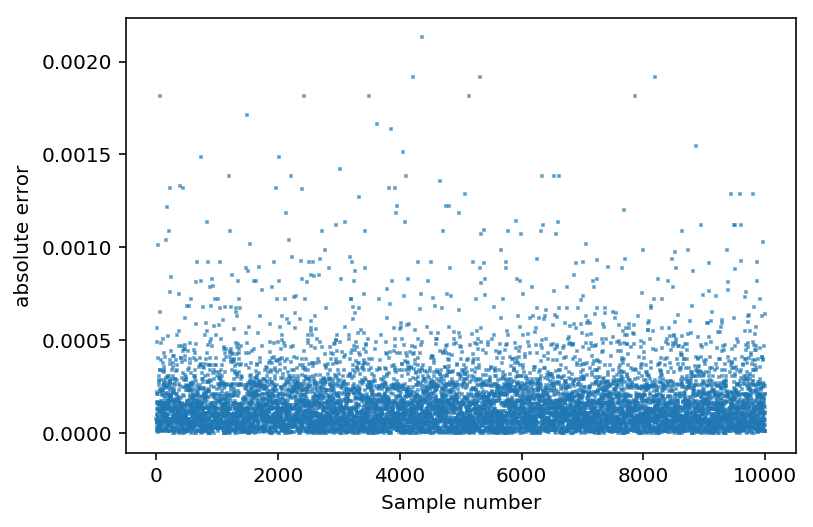

In [138]:
plt.plot(abs_errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)

print('std(error) = {}'.format(np.std(errors)))
print('percent of errors less than 0.0001 (~1ns)= {}'.format(np.mean(np.asarray(errors) < 0.0001)))
print('percent of errors less than 0.0005 (~5ns)= {}'.format(np.mean(np.asarray(errors) < 0.0005)))
print('percent of errors less than 0.00075 (~7.5ns)= {}'.format(np.mean(np.asarray(errors) < 0.00075)))

plt.xlabel('Sample number')
plt.ylabel('absolute error')
plt.show()

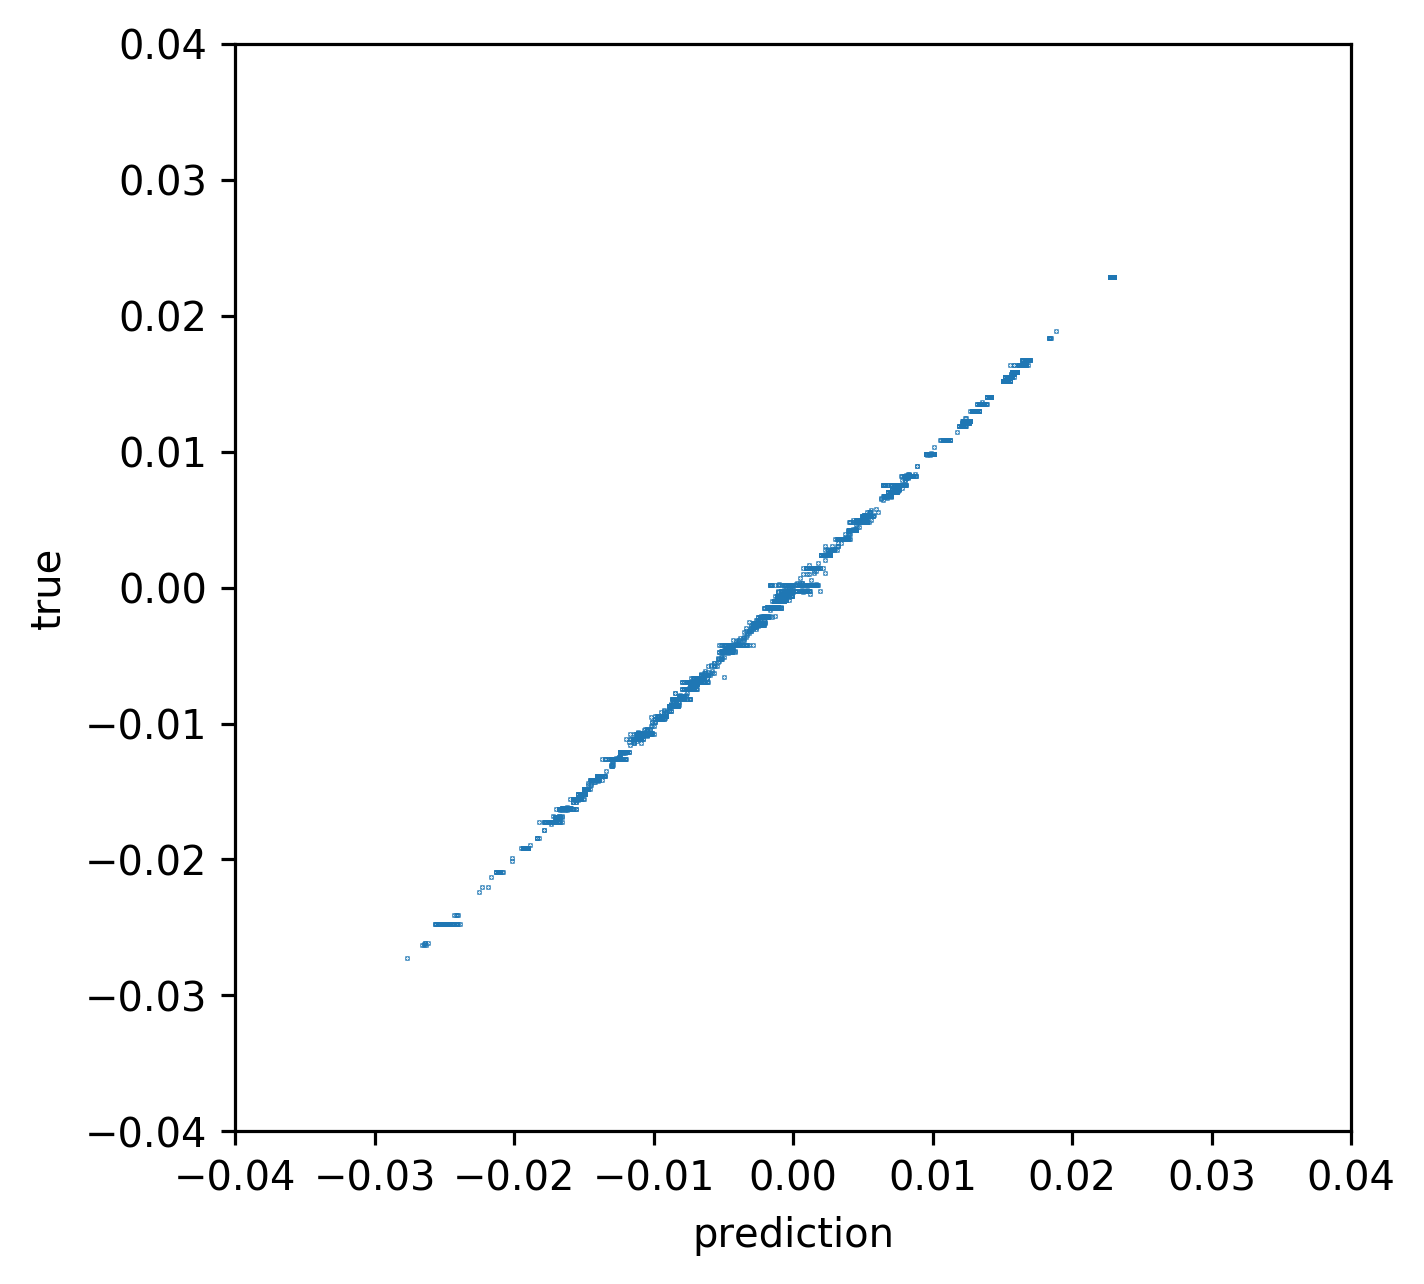

In [134]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 144)
plt.plot(best_guesses, targets, ls = 'none', marker = 's', markersize = .1, alpha = 1);
plt.xlim(-0.040, 0.040)
plt.ylim(-0.040, 0.040)
plt.xlabel('prediction')
plt.ylabel('true');

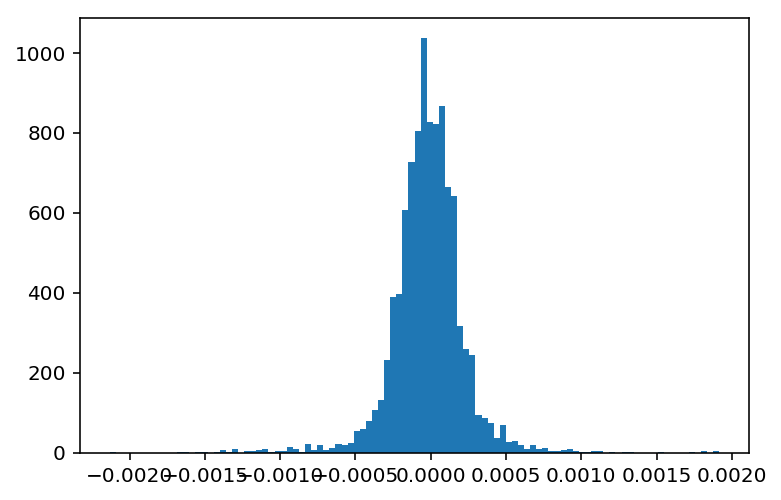

In [137]:
plt.hist(errors, bins = 100)
plt.show()

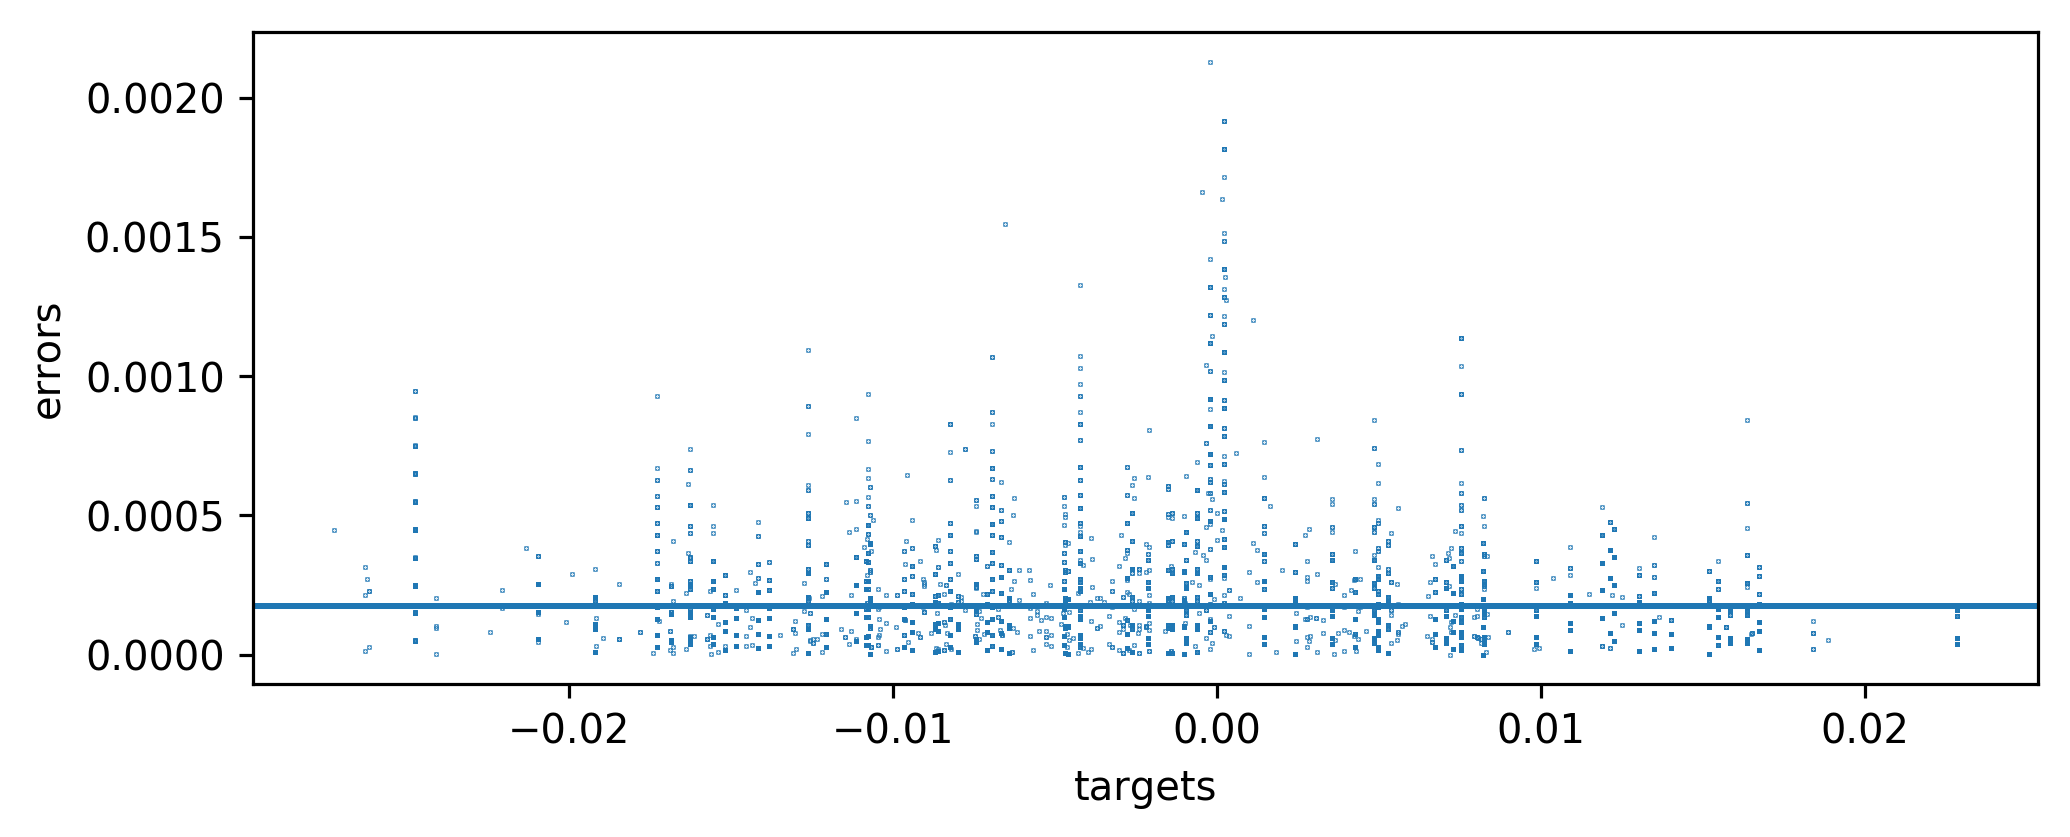

In [125]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.plot(targets, errors, ls = 'none', marker = 's', markersize = .1, alpha = 1)
# plt.xlim(-0.040, 0.040)
# plt.ylim(-0.040, 0.040)
plt.axhline(np.std(errors))
plt.xlabel('targets')
plt.ylabel('errors');

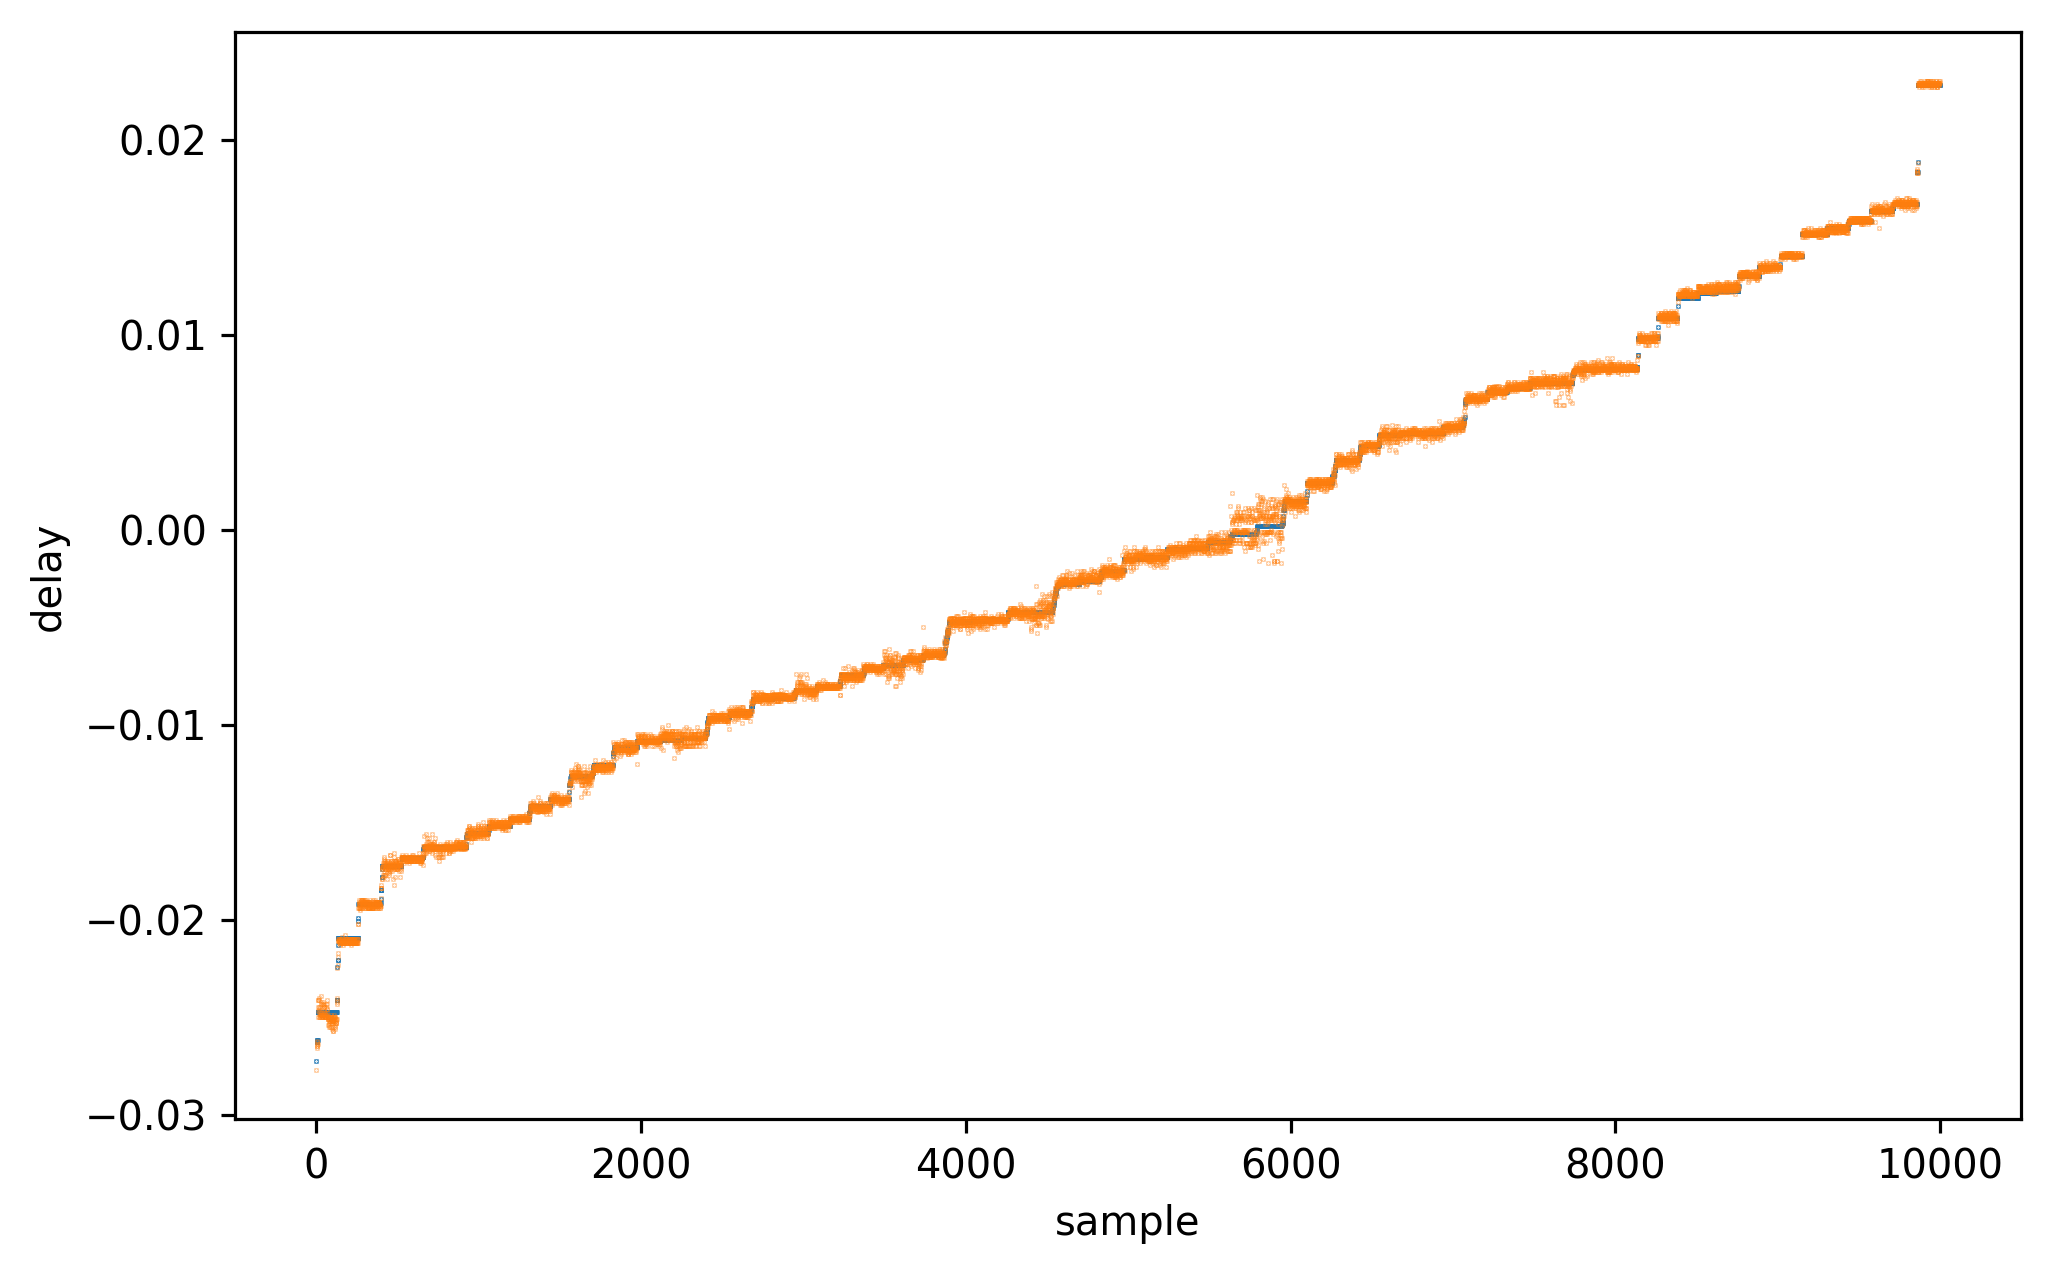

In [120]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 144)
idx = np.argsort(targets)
plt.plot(np.array(targets)[idx], ls = 'none', marker = 's', markersize = .1, alpha = 1)
plt.plot(np.array(best_guesses)[idx], ls = 'none', marker = 's', markersize = .1, alpha = 0.5)
# plt.xlim(-0.040, 0.040)
# plt.ylim(-0.040, 0.040)
plt.xlabel('sample')
plt.ylabel('delay');

***

## Assuming these results are ok, can we solve Ax = b and get realistic results?

In [89]:
def get_A_row(two_seps, max_ant_idx):
    """Contructs a row of A by placing a 1 or -1 in the index corresponding to an antenna"""

    a = np.array(two_seps).flatten()

    b = np.zeros((a.size, max_ant_idx), dtype = int)

    b[np.arange(a.size),a] = -1
    b[1] *= -1
    b[2] *= -1

    return np.sum(b, axis = 0)

In [90]:
get_A_row([(139, 142), (84, 87)], max_ant)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  1])

In [91]:
def make_A_from_list_o_sep_pairs(list_o_sep_pairs, max_ant): 

    max_ant_idx = max_ant + 1
    A = []
    for two_seps in list_o_sep_pairs:
        
        A.append(get_A_row(two_seps, max_ant_idx = max_ant_idx))

    return np.asarray(A).reshape(-1, max_ant_idx)

In [92]:
# Create A
A = make_A_from_list_o_sep_pairs(evaluation_seps, max_ant )

### take a look at A.

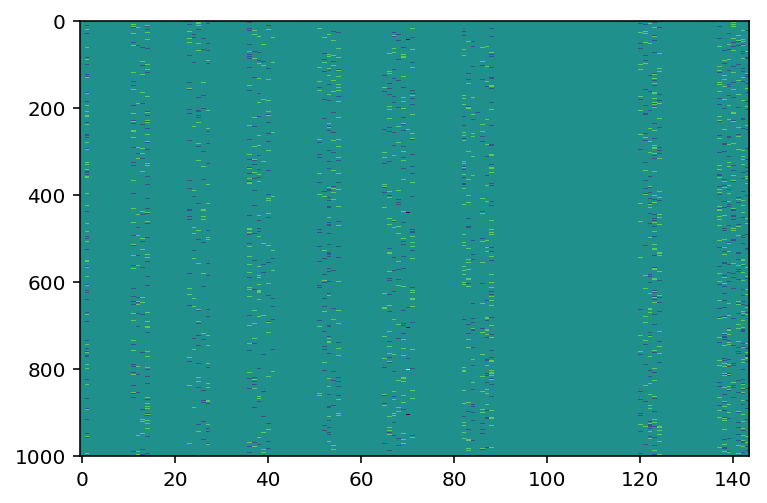

In [93]:
plt.imshow(A, aspect = 'auto');

In [94]:
# # drop the empty columns ( the antennas not present)
# # dont do and  indexing  will be easier
# A = A[:, unique_ants]

In [95]:
# create b
b = np.array(best_guesses)

Solve Ax = b

In [96]:
b.shape

(1000,)

In [97]:
# solve
x = np.linalg.lstsq(A, np.array(targets), rcond=None)[0]

In [98]:
# suppress scientific notation
np.set_printoptions(suppress=True)

In [99]:
x

array([ 0.        , -0.00075233,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.00053314,  0.00170392,  0.0008009 , -0.00149474,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.00260742,  0.0021434 ,
        0.00022184, -0.00083076,  0.00005699,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.00050421, -0.00224405, -0.00053918,  0.00142204,
       -0.00161353, -0.00028616,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00045389,  0.00258179,  0.0034209 , -0.00124853,
       -0.00076607,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00040534, -0.00085424,  0.00032512, -0.00135673, -0.00

In [100]:
x * 10000

array([  0.        ,  -7.52333887,   0.        ,  -0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,   5.33140791,
        17.03921805,   8.00898438, -14.94735244,   0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,  -0.        ,   0.        , -26.07420107,
        21.43395069,   2.21837507,  -8.30763979,   0.56987243,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         5.0420798 , -22.44048026,  -5.39183167,  14.22038468,
       -16.13526157,  -2.86161068,   0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -4.53885238,
        25.81791949,  34.20898376, -12.48528876,  -7.66066687,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [101]:
solution = {i : x[i] for i in range(len(x))}

In [102]:
keys = sorted(generated_ant_delays.keys())
sols = [solution[key] for key in keys]
trus = [generated_ant_delays[key] for key in keys]
errs = np.array(trus) - np.array(sols)

In [103]:
print(np.std(errs))
print(np.mean(errs))
print(np.median(errs))

0.00561914028082843
-0.0003033938599144434
-0.0005260849915831103


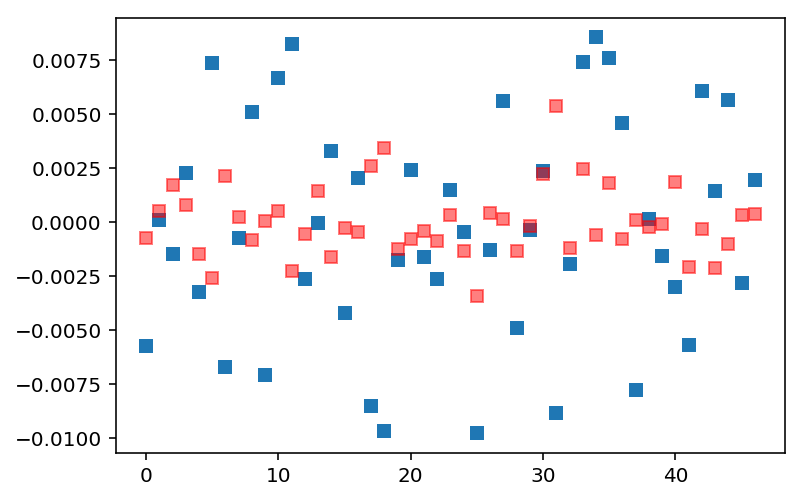

In [104]:
plt.plot(np.arange(len(sols)), trus,ls = 'none', marker = 's')
plt.plot(np.arange(len(sols)), sols,ls = 'none', marker = 's', c = 'r', alpha = 0.5)

Should we weight AX = b? if so by what?